# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## ОГЛАВЛЕНИЕ

[Описание проекта](#description)

[Цель проекта](#purpose)

[1. Изучение общей информации](#1)

- [1.1 Вывод по анализу общей информации](#1.1)

[2. Предобработка данных](#2)

- [2.1 Изменение типов данных](#2.1)

- [2.2 Обработка аномалий](#2.2)

[3. Подготовка данных](#3)

- [3.1 Преобразование категориальных признаков в числа](#3.1)

- [3.2 Разбивка на выборки](#3.2)

- [3.3 Масштабирование признаков](#3.3)

[4. Обучение моделей](#4)

- [4.1 Константная модель](#4.1)

- [4.2 Линейная регрессия](#4.2)

- [4.3 Решающее дерево](#4.3)

- [4.4 CatBoost](#4.5)

- [4.5 LightGBM](#4.5)

- [4.6 XGBoost](#4.6)

[5. Анализ моделей](#6)

- [5.1 Тестирование лучших моделей](#5.1)

- [5.2 Сравнение результатов](#5.2)

[Общий вывод](#7)

<a id='description'></a>
## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов, с помощью которого можно быстро узнать рыночную стоимость своего автомобиля. На основе исторических данных о технических характеристиках, комплектации и ценах автомобилей необходимо построить модель для определения их стоимости.  

**Признаки:**  
•	DateCrawled — дата скачивания анкеты из базы  
•	VehicleType — тип автомобильного кузова  
•	RegistrationYear — год регистрации автомобиля  
•	Gearbox — тип коробки передач  
•	Power — мощность (л. с.)  
•	Model — модель автомобиля  
•	Kilometer — пробег (км)  
•	RegistrationMonth — месяц регистрации автомобиля  
•	FuelType — тип топлива  
•	Brand — марка автомобиля  
•	NotRepaired — была машина в ремонте или нет  
•	DateCreated — дата создания анкеты  
•	NumberOfPictures — количество фотографий автомобиля  
•	PostalCode — почтовый индекс владельца анкеты (пользователя)  
•	LastSeen — дата последней активности пользователя   

**Целевой признак:**  
Price — цена (евро)


<a id='purpose'></a>
## Цель проекта

На основе исторических данных о технических характеристиках, комплектации и ценах автомобилей необходимо построить модель для определения их стоимости.  

**При выборе лучшей модели нужно учитывать:**  
•	качество предсказания;  
•	скорость предсказания;  
•	время обучения.  

Во время выполнения проекта придерживаемся следующих условий:  
1. Для оценки качества моделей используем метрику RMSE.  
2. Для начала опробуем несколько простых моделей.
3. Затем перейдем к градиентному бустингу с использоваением библиотек Catboost и LightGBM.

<a id='1'></a>
## Изучение общей информации

In [1]:
#Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor 
from catboost import cv
from catboost import Pool
import catboost as cat

from lightgbm import LGBMRegressor
import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)

In [2]:
#Прочитаем датасет
data = pd.read_csv('/datasets/autos.csv')

In [3]:
#Выведем рандомные 10 строк таблицы для знакомства с данными
data.sample(10, random_state=12345)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46
63295,2016-03-07 12:55:48,11000,wagon,2010,auto,177,5er,150000,10,gasoline,bmw,no,2016-03-07 00:00:00,0,6237,2016-04-04 02:16:33
299143,2016-03-24 17:48:59,1200,small,2003,NaN,58,clio,150000,3,petrol,renault,no,2016-03-24 00:00:00,0,25551,2016-03-24 17:48:59
236634,2016-03-27 09:57:43,12500,convertible,1977,auto,177,sl,150000,5,petrol,mercedes_benz,no,2016-03-27 00:00:00,0,53177,2016-03-27 10:38:40
44603,2016-04-02 18:38:59,1599,NaN,2016,manual,50,arosa,125000,10,NaN,seat,no,2016-04-02 00:00:00,0,2991,2016-04-06 18:16:10
251416,2016-03-20 23:53:52,1999,small,2002,manual,75,corsa,150000,1,petrol,opel,NaN,2016-03-20 00:00:00,0,46537,2016-03-21 04:41:29


In [4]:
#Выведем общую информацию для оценки количества пропусков и типов данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
#Проверим наличие грубых дубликатов
data.duplicated().sum()

4

In [6]:
#Посмотрим описательную статистику для числовых значений
data.describe(exclude=[object])

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
#Подсчитаем количество пропущенных значений в колонках
print('Доля пропущенных значений в столбце:')
((data.isna().sum() / data.shape[0]).round(2)).sort_values(ascending = False)


Доля пропущенных значений в столбце:


NotRepaired          0.20
VehicleType          0.11
FuelType             0.09
Model                0.06
Gearbox              0.06
LastSeen             0.00
PostalCode           0.00
NumberOfPictures     0.00
DateCreated          0.00
Brand                0.00
RegistrationMonth    0.00
Kilometer            0.00
Power                0.00
RegistrationYear     0.00
Price                0.00
DateCrawled          0.00
dtype: float64

In [8]:
#Определим количество нулевых значений в колонках Цена, Мощность и Месяц регистрации
columns = ['Price', 'Power', 'RegistrationMonth']
for column in columns:
    print('Доля нулевых значений в столбце {}:'.format(column), ((data[data[column]==0][column].count()) / (data.shape[0])).round(2))


Доля нулевых значений в столбце Price: 0.03
Доля нулевых значений в столбце Power: 0.11
Доля нулевых значений в столбце RegistrationMonth: 0.11


In [9]:
#Проверим количество уникальных значений в колонках с типом данных object
columns = ['VehicleType', 'FuelType', 'Model', 'Gearbox', 'Brand']
for column in columns:
    print('Уникальные значения в столбце {}:'.format(column), data[column].unique())



Уникальные значения в столбце VehicleType: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения в столбце FuelType: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
Уникальные значения в столбце Model: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicent

<a id='1.1'></a>
### Вывод по анализу общей информации

1. Датасет содержит 354369 в 16 колонках. Очевидно следующие колонки являются просто информационными и не имеют влияния на стоимость авто: Месяц регистрации (достаточно информации о годе), Дата создания анкеты, Почтовый индекс, Дата последней активности. Их необходимо удалить, чтобы не мешались. Также удалим количество фотографий, эта колонка все равно с нулями. 
2. Видим достаточно большое количество пропусков в колонках NotRepaired (20%), VehicleType (11%), FuelType (9%), Model (6%), Gearbox (6%).
3. Также видим нулевые значения в колонках Price (3%) и Power (11%). Цену можно было бы попробовать восстановить на основе объявлений с совпадениями по другим колонкам, но т.к. это наш целевой признак, думаю, не стоит манипулировать с ним. Заполнить пропуски в Мощности не представляется возможным, т.к. даже для одной модели одного года возможны комплектации с различной мощностью. Эти пропуски придется удалить.
4. Необходимо исследовать на предмет аномалий данные в колонках Price, Power, RegistrationYear. В Цене встречаются нулевые значения, возможно, есть и еще какие-то нереалистично маленькие. В Мощности, напротив, неправдоподобный максимум, возможно, есть и другие аномалии. В Годе регистрации есть выбросы в обе стороны.
5. Некорректные типы данных. В датах - но мы избавляемся от этих колонок, поэтому менять не будем. Колонку NotRepaired привести к булевому типу. Gearbox имеет всего два типа значений - его тоже можно преобразовать в булевый (переименовав, например, в Auto Gearbox)
6. Найдено 4 грубых дубликата. Т.к. таблица содержит довольно специфичные и уникальные данные (время до секунд), вероятно, это действительно дубли - можем их убрать.

<a id='2'></a>
## Предобработка данных

In [10]:
#Избавимся от ненужных колонок
data.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth'], axis = 1, inplace = True)

In [11]:
#Избавимся от грубых дубликатов
data.drop_duplicates(inplace = True)

Заполним пропуски в колонках. Для категориальных признаков будем использовать значение unknown, которое просто позволит избежать пустых строк, не искажая общую картину данных.

In [12]:
columns = ['NotRepaired', 'VehicleType', 'FuelType', 'Model', 'Gearbox']
for column in columns:
    data[column] = data[column].fillna('unknown')


In [13]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<a id='2.1'></a>
### Обработка аномалий

#### Цена

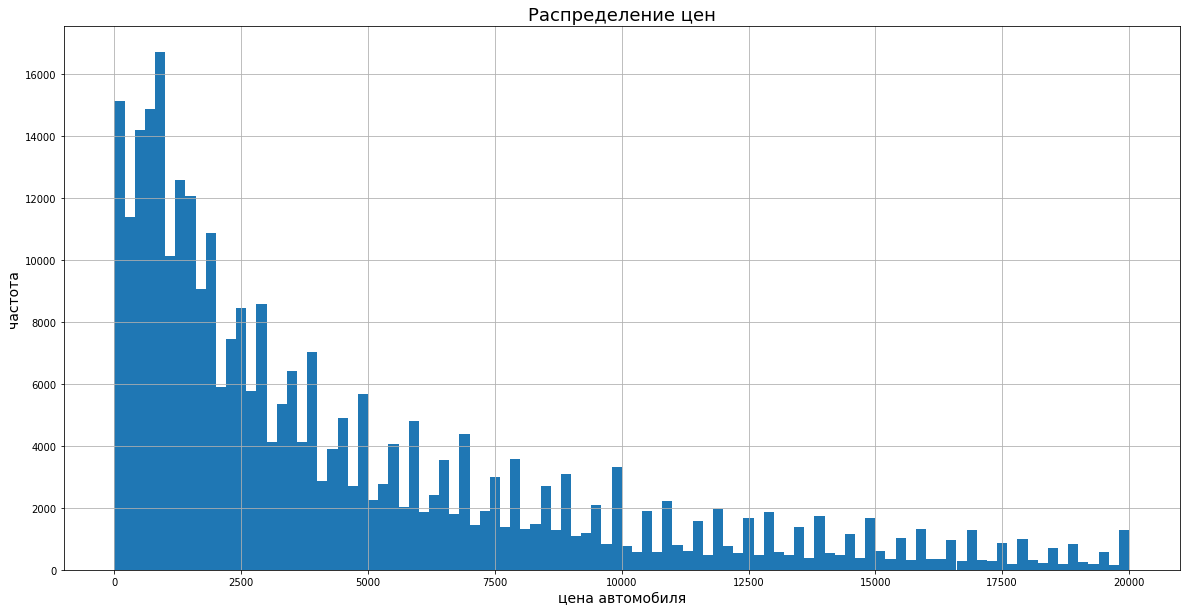

In [14]:
#Посмотрим на график распределения цен на автомобили
data['Price'].hist(bins = 100, range=(0,20000), figsize = (20,10))
plt.title("Распределение цен", fontsize = 18)
plt.ylabel("частота", fontsize = 14)
plt.xlabel("цена автомобиля", fontsize = 14) 
plt.show()

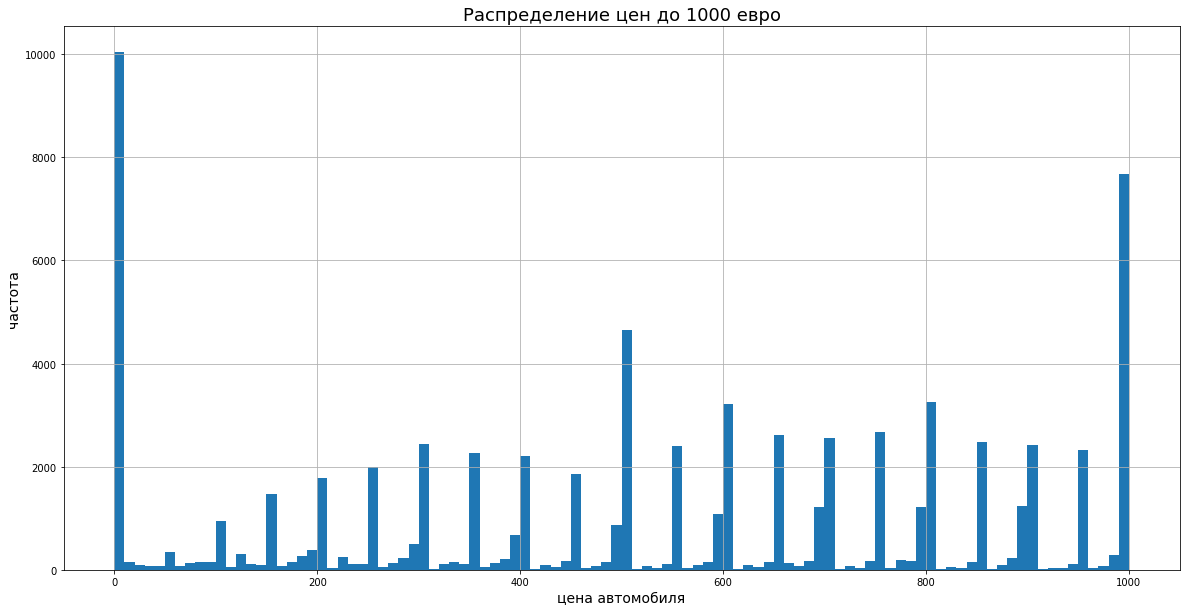

In [15]:
#Рассмотрим подробнее цены до 1000
data.query('Price <= 1000')['Price'].hist(bins = 100, range=(0,1000), figsize = (20,10))
plt.title("Распределение цен до 1000 евро", fontsize = 18)
plt.ylabel("частота", fontsize = 14)
plt.xlabel("цена автомобиля", fontsize = 14) 
plt.show()

Анализ показал нам большое количество незаполненных значений цены. Также на графике мы видим и ряд подозрительно маленьких значений. Промониторив рынок, вижу, что до 200 евро сейчас не купить даже ржавого корыта. Поэтому думаю, что можем отбросить не только нулевые значения, но и все, что ниже 200 евро. При этом верхняя граница выглядит правдноподобно, там не будем ничего удалять.

In [16]:
#Избавимся от строк с нулевыми и неправдоподобно низкими значениями цены
data_f = data[data['Price'] > 200]

#### Мощность

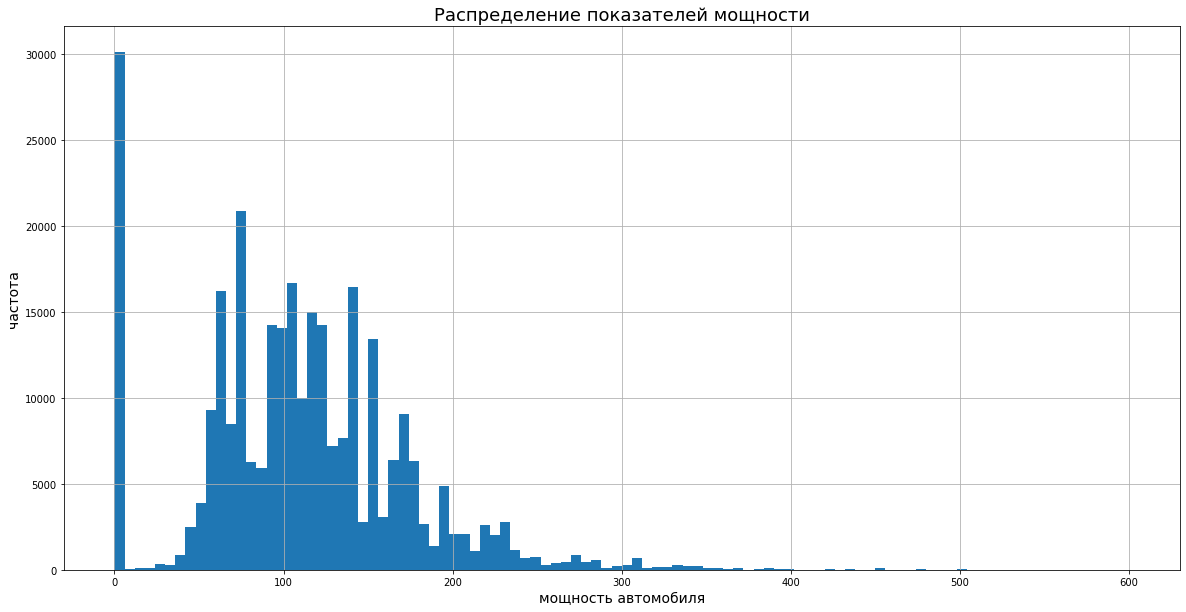

In [17]:
#Посмотрим на график распределения мощности автомобилей
data_f['Power'].hist(bins = 100, range=(0,600), figsize = (20,10))
plt.title("Распределение показателей мощности", fontsize = 18)
plt.ylabel("частота", fontsize = 14)
plt.xlabel("мощность автомобиля", fontsize = 14) 
plt.show()

Исследовав рынок, вижу, что не существует автомобилей мощностью менее 10 и более 5000 л.с. Бегло просмотрев строки с такими значениями, предполагаю, что это явные ошибки (т.к., например, мощность 2-5 л.с. записана для современных мощных авто), поэтому удаляю такие строки.

In [18]:
#Посмотрим, насколько частотны очень большие значения
data_f.query('Power > 5000')['Power'].value_counts()

12512    3
6012     2
9012     2
7511     2
12510    2
        ..
17011    1
5575     1
15017    1
13636    1
6018     1
Name: Power, Length: 68, dtype: int64

In [19]:
#Посмотрим, насколько частотны очень малые значения
data_f.query('1 < Power < 20')['Power'].value_counts()

5     93
18    44
11    27
4     26
15    19
14    19
12    18
19    14
10    11
16    11
7     10
6     10
3      9
2      9
13     8
17     8
8      7
9      4
Name: Power, dtype: int64

In [20]:
#Избавимся от строк с нулевыми, а также неправдоподобно низкими и высокими значениями мощности
data_f = data_f[(data_f['Power'] > 10) & (data_f['Power'] <=5000)]

#### Год регистрации

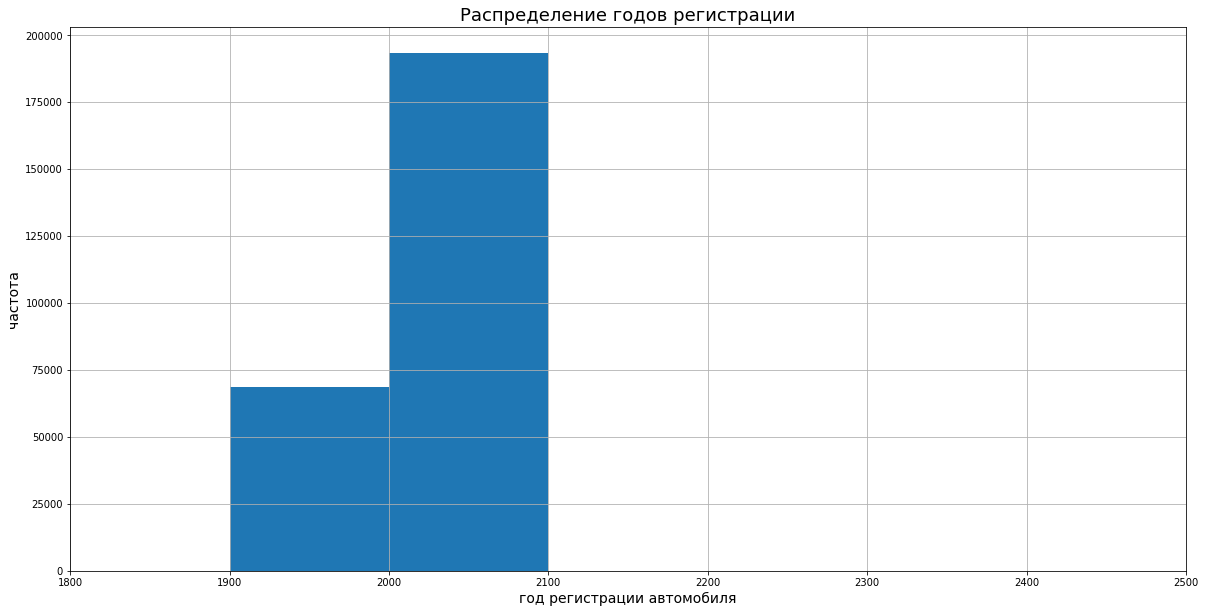

In [21]:
#Посмотрим на график распределения годов регистрации
data_f['RegistrationYear'].hist(bins = 100, range=(0,10000), figsize = (20,10))
plt.title("Распределение годов регистрации", fontsize = 18)
plt.ylabel("частота", fontsize = 14)
plt.xlabel("год регистрации автомобиля", fontsize = 14) 
plt.xlim(1800, 2500) 
plt.show()

Очевидно мы не найдем на рынке автомобилей ранее 1900 года выпуска и позднее 2021, поэтому все, что выходит за эти пределы (а в статистике были видны такие значения), удалим как выбросы

In [22]:
#Избавимся от строк с нулевыми, а также неправдоподобно низкими и высокими значениями мощности
data_f = data_f[(data_f['RegistrationYear'] > 1900) & (data_f['RegistrationYear'] <=2021)]

In [23]:
#Проверим описательную статистику после избавления от выбросов
data_f.describe(exclude=[object])

,Price,RegistrationYear,Power,Kilometer
count,262196.000000,262196.000000,262196.000000,262196.000000
mean,4980.567057,2003.466784,123.167363,127331.690796
std,4632.870137,7.085975,71.152867,37330.211365
min,202.000000,1910.000000,11.000000,5000.000000
25%,1450.000000,1999.000000,80.000000,125000.000000
50%,3300.000000,2004.000000,115.000000,150000.000000
75%,7100.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2019.000000,4700.000000,150000.000000


In [24]:
data_f.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


<a id='3'></a>
## Подготовка данных

<a id='3.1'></a>
### Преобразование категориальных признаков в числа

In [25]:
#Преобразуем категориальные признаки
data_ohe = pd.get_dummies(data_f)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Gearbox_unknown,Model_100,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_unknown,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknown,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Bra

Теперь можем удалить колонки VehicleType_unknown, FuelType_unknown, Gearbox_unknown, Model_unknown, NotRepaired_unknown, поскольку фактически они не несут никакой информации

In [26]:
#Избавимся от лишних колонок
data_ohe.drop(['VehicleType_unknown', 'FuelType_unknown', 'Gearbox_unknown', 'Model_unknown', 'NotRepaired_unknown'], axis = 1, inplace = True)

<a id='3.2'></a>
### Разбивка на выборки

In [27]:
#Выделим целевой признак и остальные для преобразованного датасета
target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)

In [28]:
#Отделим 60% для тестовой выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, target, train_size=0.6, random_state=12345)

In [29]:
#Теперь делим пополам вторую часть, чтобы получить по 20% для валидационной и тестовой выборок
features_test, features_valid, target_test, target_valid = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

In [30]:
#Проверим размеры полученных выборок
def test_percent(df1,df2,df3):
    p1 = df1.shape[0]/data_ohe.shape[0]
    p2 = df2.shape[0]/data_ohe.shape[0]
    p3 = df3.shape[0]/data_ohe.shape[0]
    print('{:.0%} {:.0%} {:.0%}'.format(p1,p2,p3))
test_percent(features_train, features_test, features_valid)

60% 20% 20%


In [31]:
#Выделим целевой признак и остальные для исходного датасета
target_raw = data['Price']
features_raw = data.drop('Price', axis=1)

In [32]:
#Отделим 60% для тестовой выборки
features_train_raw, features_valid_raw, target_train_raw, target_valid_raw = train_test_split(features_raw, target_raw, train_size=0.6, random_state=12345)

In [33]:
#Теперь делим пополам вторую часть, чтобы получить по 20% для валидационной и тестовой выборок
features_test_raw, features_valid_raw, target_test_raw, target_valid_raw = train_test_split(features_valid_raw, target_valid_raw, test_size=0.5, random_state=12345)

In [34]:
#Проверим размеры полученных выборок
def test_percent(df1,df2,df3):
    p1 = df1.shape[0]/data.shape[0]
    p2 = df2.shape[0]/data.shape[0]
    p3 = df3.shape[0]/data.shape[0]
    print('{:.0%} {:.0%} {:.0%}'.format(p1,p2,p3))
test_percent(features_train_raw, features_test_raw, features_valid_raw)

60% 20% 20%


<a id='3.3'></a>
### Масштабирование признаков

После того, как мы разбили исходный датасет на выборки для обучения модели, стандартизируем числовые признаки и настроим их на обучающих данных.

In [35]:
data_ohe.head(2)

,Price,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Model_100,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
1,18300,20

In [36]:
#Заведем словарь с числовыми признаками
numeric = ['RegistrationYear', 'Power', 'Kilometer']

In [ ]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [37]:
#Настроим стандартизацию на обучающей выборке для преобразованных и непреобразованных выборок
scaler = StandardScaler()
scaler.fit(features_train[numeric])
scaler.fit(features_train_raw[numeric])

#Отключаем предупреждение SettingWithCopy
pd.options.mode.chained_assignment = None

#Сохраним преобразованные выборки в соответствующих переменных для преобразованных выборок
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#И для непреобразованных
features_train_raw[numeric] = scaler.transform(features_train_raw[numeric])
features_valid_raw[numeric] = scaler.transform(features_valid_raw[numeric])
features_test_raw[numeric] = scaler.transform(features_test_raw[numeric])

#Посмотрим, что получилось
features_train.head()

,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Model_100,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_alfa_romeo,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
139827,-0.124005

Мы подготовили задел для увеличения качества модели: избавились от пропусков и лишних столбцов, преобразовали в численную форму категориальные признаки и привели разнокалиберные численные к единому масштабу. Подготовленные данные разбиты на три выборки, теперь можно переходить к подбору наиболее эффективной модели обучения.

<a id='4'></a>
## Обучение моделей

Для начала попробуем обучить простые модели, чтобы было на что опираться при оценке качества, затем перейдем к градиентному бустингу.

<a id='4.1'></a>
### Константная модель

In [38]:
predicted_valid_const = pd.Series(target_train.mean(), index=target_valid.index)
rmse_const = mean_squared_error(target_valid, predicted_valid_const)**0.5

print('RMSE константной модели: {:.2f}'.format(rmse_const))

RMSE константной модели: 4616.39


<a id='4.2'></a>
### Линейная регрессия

In [39]:
%%time

lr = LinearRegression(normalize=True)
lr.fit(features_train, target_train)


CPU times: user 11.7 s, sys: 3.82 s, total: 15.5 s
Wall time: 15.5 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [40]:
%%time
predictions_lr = lr.predict(features_valid)
print("RMSE линейной регрессии: ", mean_squared_error(target_valid, predictions_lr)**(0.5))

RMSE линейной регрессии:  2756.625823724701
CPU times: user 88.9 ms, sys: 69.3 ms, total: 158 ms
Wall time: 115 ms


<a id='4.3'></a>
### Решающее дерево

In [41]:
#Подберем лучшие гиперпараметры
#params_dtr = {
   # 'max_depth': range(1, 50),
   # 'min_samples_split': range(2, 20), 
   # 'min_samples_leaf': range(1, 5)
   # }


#dtr = DecisionTreeRegressor(random_state=12345)
#grid_dtr = GridSearchCV(estimator=dtr, param_grid=params_dtr, cv=5, scoring='neg_mean_squared_error')
#grid_dtr.fit(features_train, target_train)

#print("Лучшие гиперпараметры: ", grid_dtr.best_params_)

Теперь обучим модель на лучших гиперпараметрах и замерим скорость

In [42]:
%%time
dtr_best = DecisionTreeRegressor(max_depth=50, min_samples_split=20, min_samples_leaf=2, random_state=12345)
dtr_best.fit(features_train, target_train)

CPU times: user 5.41 s, sys: 50.5 ms, total: 5.46 s
Wall time: 5.46 s


DecisionTreeRegressor(criterion='mse', max_depth=50, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [43]:
%%time
predictions_dtr_best = dtr_best.predict(features_valid)
print("RMSE решающего дерева: ", (mean_squared_error(target_valid, predictions_dtr_best))**(0.5))

RMSE решающего дерева:  1858.3504779319417
CPU times: user 64 ms, sys: 41.9 ms, total: 106 ms
Wall time: 112 ms


<a id='4.4'></a>
### CatBoost

In [48]:
#Запишем словарь категориальных признаков

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [ ]:
#Подберем лучшие гиперпараметры
#params_cat = {
   # 'depth': [6, 8, 10, 16],
   # 'iterations': [10, 20, 50, 100],
   # 'learning_rate': [0.1, 0.2, 0.3]
   # }

#cat = CatBoostRegressor()
#grid_cat = GridSearchCV(estimator=cat, param_grid=params_cat, cv=5, scoring='neg_mean_squared_error')
#grid_cat.fit(features_train, target_train, verbose=5)

#print("Лучшие гиперпараметры: ", grid_cat.best_params_)

Теперь обучим модель на лучших гиперпараметрах и замерим скорость

In [49]:
%%time
cat_best = CatBoostRegressor(depth=16, iterations=100, learning_rate=0.1, verbose=5)
cat_best.fit(features_train_raw, target_train_raw, cat_features=cat_features)

0:	learn: 4243.7603828	total: 3.42s	remaining: 5m 38s
5:	learn: 3146.9109904	total: 9.41s	remaining: 2m 27s
10:	learn: 2568.9133007	total: 21.7s	remaining: 2m 55s
15:	learn: 2212.7990123	total: 33.3s	remaining: 2m 55s
20:	learn: 2010.7327706	total: 45.8s	remaining: 2m 52s
25:	learn: 1895.3233962	total: 57.9s	remaining: 2m 44s
30:	learn: 1815.0610920	total: 1m 9s	remaining: 2m 35s
35:	learn: 1767.2151010	total: 1m 21s	remaining: 2m 25s
40:	learn: 1730.4909571	total: 1m 33s	remaining: 2m 14s
45:	learn: 1703.3012051	total: 1m 45s	remaining: 2m 3s
50:	learn: 1681.7386946	total: 1m 57s	remaining: 1m 52s
55:	learn: 1663.3605876	total: 2m 9s	remaining: 1m 41s
60:	learn: 1647.5123777	total: 2m 21s	remaining: 1m 30s
65:	learn: 1629.9560337	total: 2m 34s	remaining: 1m 19s
70:	learn: 1616.7676265	total: 2m 45s	remaining: 1m 7s
75:	learn: 1604.4776584	total: 2m 57s	remaining: 56.2s
80:	learn: 1593.8496975	total: 3m 7s	remaining: 44s
85:	learn: 1585.4891785	total: 3m 17s	remaining: 32.1s
90:	learn:

In [50]:
%%time
predictions_cat_best = cat_best.predict(features_valid_raw)
print("RMSE CatBoost: ", (mean_squared_error(target_valid_raw, predictions_cat_best))**(0.5))

RMSE CatBoost:  1840.525246340906
CPU times: user 204 ms, sys: 18.2 ms, total: 222 ms
Wall time: 198 ms


<a id='4.5'></a>
### LightGBM

In [ ]:
#Подберем лучшие гиперпараметры
#params_light = {
   # 'num_leaves': [10, 20, 30, 70],
   # 'max_depth': range(-5, -1),
   # 'n_estimators':[80, 100, 150]
   # }

#light = LGBMRegressor()
#grid_light = GridSearchCV(estimator=light, param_grid=params_light, cv=5, scoring='neg_mean_squared_error')
#grid_light.fit(features_train, target_train)

#print("Лучшие гиперпараметры: ", grid_light.best_params_)

In [51]:
#Заменим тип данных у категориальных признаков
cat_feature = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for column in cat_feature:
    features_train_raw[column] = features_train_raw[column].astype('category')
    features_test_raw[column] = features_test_raw[column].astype('category')
    features_valid_raw[column] = features_valid_raw[column].astype('category')

In [52]:
features_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185597 entries, 284761 to 240759
Data columns (total 9 columns):
VehicleType         185597 non-null category
RegistrationYear    185597 non-null float64
Gearbox             185597 non-null category
Power               185597 non-null float64
Model               185597 non-null category
Kilometer           185597 non-null float64
FuelType            185597 non-null category
Brand               185597 non-null category
NotRepaired         185597 non-null category
dtypes: category(6), float64(3)
memory usage: 6.9 MB


Теперь обучим модель на лучших гиперпараметрах и замерим скорость


In [53]:
%%time
light_best = LGBMRegressor(num_leaves=70, max_depth=-5, n_estimators=150)
light_best.fit(features_train_raw, target_train_raw)

CPU times: user 2.56 s, sys: 28.4 ms, total: 2.59 s
Wall time: 2.58 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_leaves=70, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [58]:
%%time
predictions_light_best = light_best.predict(features_valid_raw)
print("RMSE LightGBM: ", (mean_squared_error(target_valid_raw, predictions_light_best))**(0.5))

RMSE LightGBM:  1780.8316566842252
CPU times: user 877 ms, sys: 2.17 ms, total: 879 ms
Wall time: 877 ms


<a id='4.6'></a>
### XGBoost

In [ ]:
#Подберем лучшие гиперпараметры
#params_xgbr = {
    #'min_split_loss': range(0, 10),
   # 'max_depth': range(6, 10)
   # }

#xgbr = XGBRegressor()
#grid_xgbr = GridSearchCV(estimator=light, param_grid=params_xgbr, cv=5, scoring='neg_mean_squared_error')
#grid_xgbr.fit(features_train, target_train)

#print("Лучшие гиперпараметры: ", grid_xgbr.best_params_)

Теперь обучим модель на лучших гиперпараметрах и замерим скорость

In [44]:
%%time
xgbr_best = XGBRegressor(min_split_loss=0, max_depth=9)
xgbr_best.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:22:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 53s, sys: 972 ms, total: 3min 53s
Wall time: 3min 58s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=1, min_split_loss=0, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [45]:
%%time
predictions_xgbr_best = xgbr_best.predict(features_valid)
print("RMSE XGBoost: ", (mean_squared_error(target_valid, predictions_xgbr_best))**(0.5))

RMSE XGBoost:  1657.9390071564742
CPU times: user 525 ms, sys: 141 ms, total: 665 ms
Wall time: 663 ms


**Вывод**. Все рассмотренные модели показали существенно лучшее качество, чем константная. Наилучшие результаты по качеству показали модели градиентного бустинга. Подобранные на настоящий момент гиперпараметры вывели на первое место по качеству модель XGBoost, однако она довольно медленная. Наиболее быстрой является модель LightGBM, по качеству она на втором месте. Далее проверим все три модели градиентного бустинга на тестовой выборке.

## Анализ моделей

<a id='5.1'></a>
### Тестирование лучших моделей

In [46]:
#Функция для предсказания на тестовой выборке
def model(params, model_name, features_test, target_test):
    predictions_test = model_name.predict(features_test)
    print("RMSE модели: ", mean_squared_error(target_test, predictions_test)**(0.5))

Сделаем предсказание на тестовой выборке и замерим время для модели LightGBM

In [55]:
%%time
params = {'num_leaves':70, 'max_depth':-5, 'n_estimators':150}
model(params, light_best, features_test_raw, target_test_raw)

RMSE модели:  1787.7563094592736
CPU times: user 866 ms, sys: 1.82 ms, total: 867 ms
Wall time: 866 ms


Сделаем предсказание на тестовой выборке и замерим время для модели CatBoost

In [56]:
%%time
params = {'depth':16, 'iterations':100, 'verbose':5}
model(params, cat_best, features_test_raw, target_test_raw)

RMSE модели:  1842.8323003326827
CPU times: user 154 ms, sys: 16.2 ms, total: 170 ms
Wall time: 114 ms


Сделаем предсказание на тестовой выборке и замерим время для модели XGBoost

In [47]:
%%time
params = {'max_depth':9, 'min_split_loss':0}
model(params, xgbr_best, features_test, target_test)

RMSE модели:  1661.5032466517625
CPU times: user 544 ms, sys: 173 ms, total: 717 ms
Wall time: 719 ms


Тестирование показало, что лучший результат по качеству по-прежнему у модели LightGBM. По сравнению с предсказаниями на валидационной выборке качество предсказаний у моделей ухудшилось, но совсем незначительно, это нормально.

<a id='5.2'></a>
### Сравнение моделей

Выведем итоговую сравнительную таблицу для всех рассмотренных моделей. Вносить будем результаты, полученные на валидационной выборке.

In [57]:
#Итоговая таблица сравнения моделей 
data = [["15.5 s", "115 ms", 2756],
        ["5.46 s", "112 ms", 1858],
        ["3 min 5 s", "198 ms", 1840],
        ["2.58 s", "984 ms", 1780],
        ["3 min 58 s", "663 ms", 1657]]
model = ["Линейная регрессия", "Решающее дерево", "CatBoost", "LightGBM", "XGBoost"]

pd.DataFrame(data=data, index=model, columns=["Время обучения", "Время предсказания", "RMSE"])

,Время обучения,Время предсказания,RMSE
Линейная регрессия,15.5 s,115 ms,2756
Решающее дерево,5.46 s,112 ms,1858
CatBoost,3 min 5 s,198 ms,1840
LightGBM,2.58 s,984 ms,1780
XGBoost,3 min 58 s,663 ms,1657


**Вывод.** Лучшие результаты по качеству показала модель XGBoost, однако по скорости она - самая медленная из всех. Лучше всего по скорости - модель LightGBM, она же на втором месте по качеству. Так как в ТЗ не заданы ориентиры по приемлемому времени обучения, мы не знаем, насколько подходит скорость XGBoost. Если она слишком медленная, то можно взять LightGBM, полагаю, что если потратить на тюнинг больше времени, ее качество можно будет повысить.

Модель решающего дерева также показала неплохие результы - высокую скорость обучения и предсказания при хорошем показателе качества. Возможно, если тщательней подойти к подбору гиперпараметров, можно было бы остановиться на решающем дереве как наиболее простой и быстрой модели. Но при текущем раскладе оставляем настоящего лидера по качеству.  

**Для определения рыночной стоимости автомобиля для сервиса "Не бит, не крашен" рекомендуется модель градиентного бустинга XGBoost (по самому высокому качеству) или LightGBM (самая быстрая и вторая по качеству)**